# AdaBoostClassifier

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.ensemble         import AdaBoostClassifier
from sklearn.tree             import DecisionTreeClassifier,ExtraTreeClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [2]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = True
engineering = False

submission_filename = "../submissions/submission_AdaBoostClassifier.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train the model

In [4]:
%%time

random.seed(SEED)

clf = AdaBoostClassifier(base_estimator = None,      # default=DecisionTreeClassifier
                         n_estimators   = 50, 
                         learning_rate  = 1.0, 
                         algorithm      = 'SAMME.R', # 'SAMME', 'SAMME.R' 
                         random_state   = SEED)



# StatifiedCV = StratifiedKFold(y            = y_train, 
#                               n_folds      = 10, 
#                               shuffle      = True, 
#                               random_state = SEED)

# param_grid = dict(n_estimators   = [100, 150, 200, 250, 500],
#                   learning_rate  = [0.001, 0.01, 0.1, 1.0],
#                   algorithm      = ['SAMME', 'SAMME.R'])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV,
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME'}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 260 ms


In [5]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


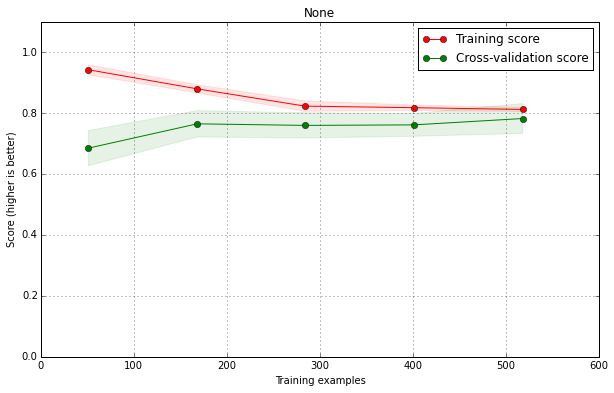

CPU times: user 240 ms, sys: 24 ms, total: 264 ms
Wall time: 3.39 s


In [6]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [7]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

try:
    predicted_probs  = clf.predict_proba(X_train)
    probs_avail = True
except AttributeError,e:
    probs_avail = False
    print(e)

[[413  25]
 [ 85  53]]


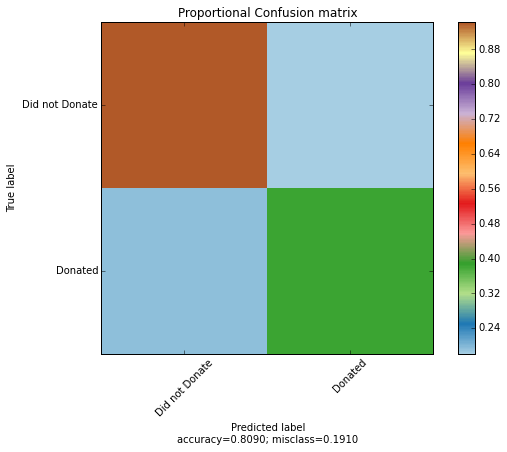

Accuracy 0.809, mis-class rate 0.191


In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

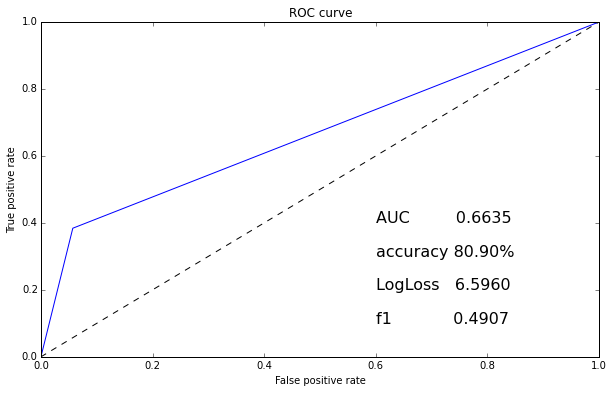

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Load the test data

In [57]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [58]:
y_pred        = clf.predict(X_test)
if probs_avail:
    y_pred_probs  = clf.predict_proba(X_test)
    donate_probs  = [prob[1] for prob in y_pred_probs]
else:
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]

In [59]:
print(y_pred[:10])
if probs_avail: print(y_pred_probs[:10])
print(donate_probs[:10])

[0 0 0 0 1 1 0 0 0 0]
[[ 0.50260385  0.49739615]
 [ 0.52275039  0.47724961]
 [ 0.50777158  0.49222842]
 [ 0.52203051  0.47796949]
 [ 0.500061    0.499939  ]
 [ 0.49521027  0.50478973]
 [ 0.50570909  0.49429091]
 [ 0.53026219  0.46973781]
 [ 0.59065474  0.40934526]
 [ 0.53137294  0.46862706]]
[0.49739614781902902, 0.47724960567547936, 0.49222842246701093, 0.47796949360894236, 0.4999390049661796, 0.50478972796656763, 0.49429091328978403, 0.46973781164731376, 0.40934525888360018, 0.46862705740284788]


# Create the submission file

In [60]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()